In [2]:
"This notebook uses an alternative method GRISLI for inferring gene regulation networks and calculating frustration."

'This notebook uses an alternative method GRISLI for inferring gene regulation networks and calculating frustration.'

In [1]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
# import scvelo as scv
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
import glob
import anndata
from scipy.interpolate import CubicSpline,interp1d
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix

from joblib import Parallel, delayed
import pandas as pd
from tigress import _bootstrap_generator,_subsampling_generator,_fit_bootstrap_sample,StabilizedSelection,TIGRESS
from sklearn.linear_model import LinearRegression

In [2]:
dim_n=10
result_path='result/'
adata=dyn.read(result_path+'EG_dyn.h5ad')

path=np.load(result_path+'EG_dyn_rc.npy')
rc_extend=np.load(result_path+'EG_rc_extend.npy')

gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)


In [4]:
V0_ori=adata.layers['velocity_S'].A
X0_ori=adata.layers['M_s'].A

In [5]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X0_ori=imp_mean.fit_transform(X0_ori)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

V0_ori=imp_mean.fit_transform(V0_ori)
V0_ori.shape

(1731, 470)

In [6]:
bin_centers=np.load(result_path+'EG_bin_genes_center.npy',allow_pickle=True)
X0_bin=X0_ori.copy()
for i in range(X0_ori.shape[1]):
    gene_kc=bin_centers[i,:]
    x=X0_ori[:,i]
    x_dist0=abs(x-gene_kc[0])
    x_dist1=abs(x-gene_kc[1])
#     print(x_dist0)
    
#     print(x_dist0<x_dist1)
    
    X0_bin[:,i][x_dist0<x_dist1]=0
    X0_bin[:,i][x_dist0>=x_dist1]=1

In [7]:
X0=StandardScaler().fit_transform(X0_ori)
V0=StandardScaler().fit_transform(V0_ori)
print(X0.shape,V0.shape)
gene_list=adata.var.index.values

(1731, 470) (1731, 470)


In [8]:
data_rc=np.array([np.argmin(np.linalg.norm((adata.obsm['X_pca'][i,:dim_n]-rc_extend),axis=1)) for i in range(adata.shape[0])])
np.unique(data_rc,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=int64),
 array([  7, 119,  50,  52,  56,  66, 104, 150, 111,  98,  89, 107, 155,
        114, 128, 253,  72], dtype=int64))

In [9]:
path_neigh=[[] for i in range(rc_extend.shape[0])]
for i in range(rc_extend.shape[0]):
#     mask=np.in1d(np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200],np.where(data_rc==i)[0])
#     path_neigh[i]=np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200][mask][:100].tolist()
#     print(len(path_neigh[i]))
    mask=np.in1d(np.where(data_rc==i)[0],np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-rc_extend[i,:]),axis=1))[:200])
    path_neigh[i]=np.where(data_rc==i)[0][mask].tolist()
    print(len(path_neigh[i]))

7
119
50
52
56
66
104
137
89
84
82
92
116
80
96
164
71


In [10]:
sel=[j for nei in path_neigh[1:-1] for j in nei]
X0_ori_sel=X0_ori[np.unique(np.asarray(sel).flatten()),:]
X0_sel=StandardScaler().fit_transform(X0_ori_sel)
V0_ori_sel=V0_ori[np.unique(np.asarray(sel).flatten()),:]
V0_sel=StandardScaler().fit_transform(V0_ori_sel)

In [11]:
X0_bin[np.where(X0_bin==0)]=-1
X0_bin.shape

(1731, 470)

In [12]:
def net_frustration(X,V,F):
    frus_score=[]
    V_sign=np.sign(V)
#     F_sign=np.sign(F)
    for i in range(V.shape[0]):
        F_sign=np.sign((X[i,:]>0).astype(np.int)*((F*X[i,:]).T))
#         F_sign=np.sign(X[i,:]*((F*X[i,:]).T))
        edge_frus=F_sign#V_sign[i,:]*F_sign
#         print(np.sum(edge_frus),np.count_nonzero(F_sign))
        frus_ratio=(np.count_nonzero(F_sign)-np.sum(edge_frus))*0.5/np.count_nonzero(F)
        frus_score.append(frus_ratio)
    return np.array(frus_score)

In [13]:
def net_H(X,V,F):
    pseudo_h=[]
    V_sign=np.sign(V)
#     F_sign=np.sign(F)
    for i in range(V.shape[0]):
        F_sign=np.sign((X[i,:]>0).astype(np.int)*((F*X[i,:]).T))

        pseudo_h.append(-np.sum(F_sign))
    return np.array(pseudo_h)

In [14]:
"GRISLI calcualte the score between "predictor" variables and "response" variables with TIGRESS method."

In [15]:
n=V0_sel.shape[1]
tig_score=np.zeros((n,n))
for i in range(V0_sel.shape[1]):
    v=V0_sel[:,i][:,None]
    tig=TIGRESS(R=50,L=50).fit(X0_sel,v)
    tig_score[:,i]=tig.scores_.values[:,0]

(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)


(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)
(470, 50)


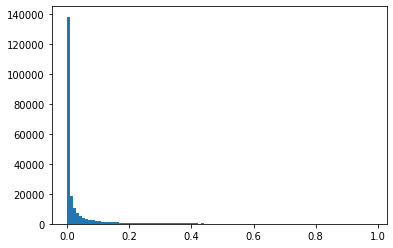

In [16]:
plt.hist(tig_score.flatten(),bins=100)
plt.show()

In [ ]:
"by setting a threshold on the TIGRESS score, the most significant regulation relation are inferred"

In [23]:
tig_score_thres=0.5
tig_score_mask=tig_score>tig_score_thres

np.where(tig_score_mask)[0].shape

(5070,)

In [24]:
np.save(result_path+'EG_tig_score.npy',tig_score)

In [15]:
tig_score=np.load(result_path+'EG_tig_score.npy')

In [25]:
n=V0_sel.shape[1]
F=np.zeros((n,n))
for i in range(n):

    
    r_inds=np.where(tig_score_mask[:,i])[0]
    if len(r_inds)>0:
        x=X0_sel[:,r_inds]
        reg = LinearRegression().fit(x, V0_sel[:,i])
        F[r_inds,i]=reg.coef_


In [26]:
np.save(result_path+'grisli_EG_F.npy',F)

In [16]:
F=np.load(result_path+'grisli_EG_F.npy')

C:\Users\zoro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


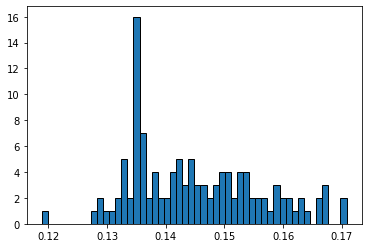

0.14510964148973202


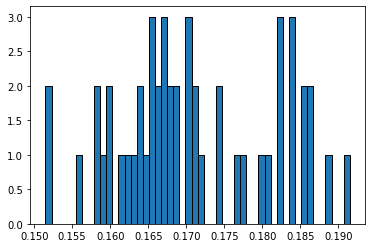

0.17099802761341223


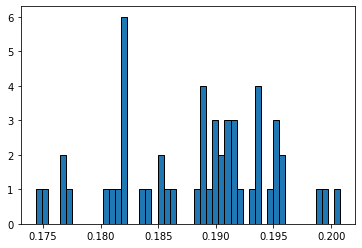

0.1882301623425884


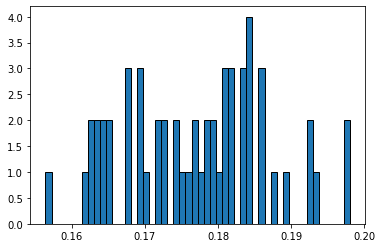

0.1769723865877712


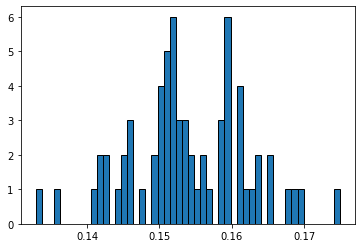

0.15389994620763853


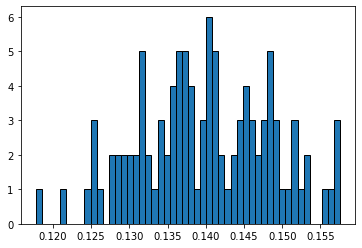

0.1399010013654984


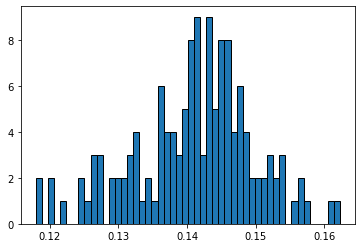

0.1409018269770656


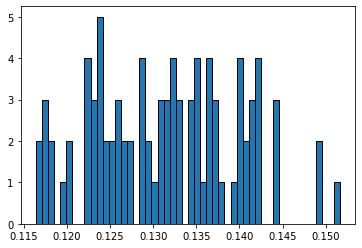

0.1314362963455444


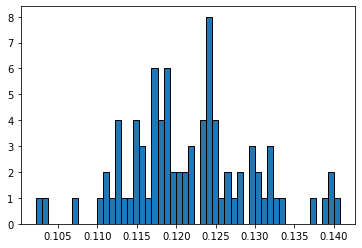

0.12169155630694094


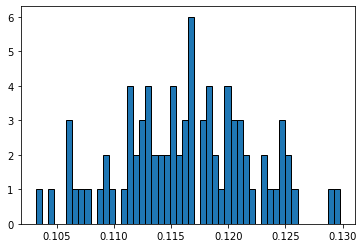

0.11627940539760426


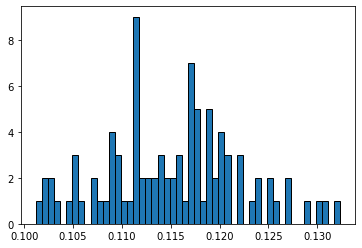

0.11517451333504845


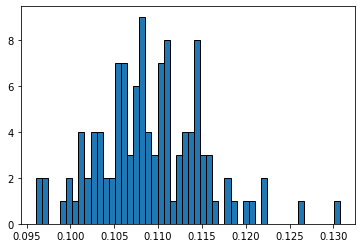

0.10912058763517651


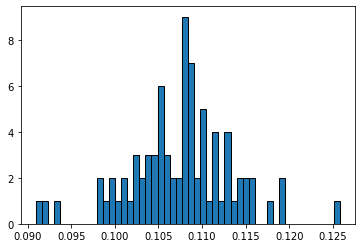

0.10751232741617356


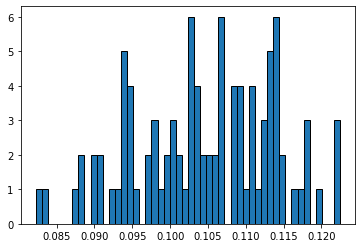

0.10462483563445102


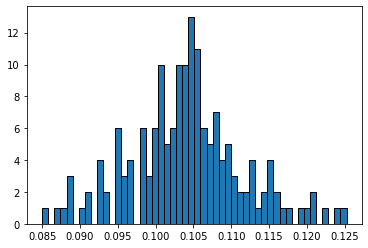

0.1040794727473902


In [17]:
frus_scores=[]
path_frus=[]

pseudo_H=[]
path_H=[]

for i in range(1,rc_extend.shape[0]-1):

        
    

    X=X0[path_neigh[i]]
    V=V0[path_neigh[i]]
#     print(path_neigh[i])
    
    X_ori=X0_ori[path_neigh[i]]
    V_ori=V0_ori[path_neigh[i]]
    X_bin=X0_bin[path_neigh[i]]


    group_frus_score=net_frustration(X_bin,V_ori,F)
    plt.hist(group_frus_score,bins=50,edgecolor='k')
    plt.show()
    frus_scores.append(group_frus_score)
    
    path_frus.append(np.mean(group_frus_score))
    print(np.mean(group_frus_score))
    group_H=net_H(X_bin,V_ori,F)
    pseudo_H.append(group_H)
    path_H.append(np.mean(group_H))

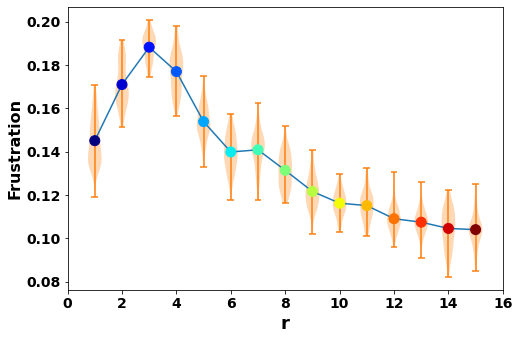

In [20]:
fig,ax=plt.subplots(figsize=(7.8,5.2))
dot_color=np.arange(path.shape[0])
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(path.shape[0])+1,path_frus)

plt.violinplot(frus_scores,positions=np.arange(path.shape[0])+1)
plt.scatter(np.arange(path.shape[0])+1,path_frus,s=100,c=dot_color,cmap=cm,zorder=10)
plt.ylabel('Frustration',fontsize=16,fontweight='bold')
plt.xlabel('r',fontsize=18,fontweight='bold')

plt.xticks(np.arange(17,step=2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
# plt.axis([0,16,0,0.4])
plt.savefig(result_path+'EG_grisli_frus.png',dpi=300)
plt.show()